## Chapter Goals
    
    1. Use GMM to predict return distribution for chosen lookahead period
    2. Evaluate GMM accuracy in predicting confidence intervals
    3. Design and implement an event study based on "outlier" returns
    4. Evaluate Event Study
    5. Improve Model by Adding Economic Features
    6. Conclusions

In [1]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time
from itertools import count

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set plot globals
plt.style.use('bmh') 
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,8
#plt.rcParams['axes.facecolor'] = sns.xkcd_rgb['gunmetal']

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,mizani,pyarrow

2017-12-05T13:56:29-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/home/bcr/anaconda3/envs/bayesian/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+9.g6519baa
mizani 0.4.2
pyarrow 0.7.1


## Using GMMs to Predict Return Distributions for Lookahead Periods

In this section we will implement a GMM to iteratively predict the distribution for our lookahead period. To do this we will make sure of `sklearn's` `TimeSeriesSplit()` function, which increments train/test data sets sequentially. This is to avoid the loss of autocorrelation information caused by using traditional cross validation techniques, which assume that the data is [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). 

In [2]:
load_parquet = lambda fp: (pq.read_table(fp).to_pandas().assign(year=lambda df: df.index.year).loc['2005':])

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = load_parquet(load_fp)
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 EEM       EFA       GLD       QQQ       SPY       TLT  year
Date                                                                        
2017-09-25 -0.017113 -0.005719  0.010413 -0.010588 -0.002047  0.006240  2017
2017-09-26 -0.002694 -0.002208 -0.011225  0.002588  0.000602 -0.001813  2017
2017-09-27 -0.003603  0.000737 -0.009465  0.008970  0.003887 -0.015183  2017
2017-09-28 -0.000677  0.002647  0.001884 -0.000346  0.001199 -0.002968  2017
2017-09-29  0.011447  0.005858 -0.005168  0.007176  0.003509  0.002247  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 7 columns):
EEM     3209 non-null float64
EFA     3209 non-null float64
GLD     3209 non-null float64
QQQ     3209 n

In [3]:
sym = 'SPY' # example symbol
s = rdf[sym].copy() 
s.to_frame().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 1 columns):
SPY    3209 non-null float64
dtypes: float64(1)
memory usage: 50.1 KB


In [4]:
#td = (s.index.max() - s.index.min()).days#/np.timedelta64(1, 'W') # number of weeks
n_split = len(s) - 1# math.ceil(td)
n_split

3208

In [79]:
### add these funcs to a model util script

def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      init_params='random',
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

In [80]:
%%time

np.random.seed(0)

lookback = 252 * 3
n_components = 5 # experiment

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.99 # for sampling confidence intervals
pred_rows = [] # init list to hold df rows
c = count(1) # init counter
for i, (train, test) in enumerate(tscv.split(s)):
    if next(c) < lookback: # add training data until min lookback
        continue

    ### set up train/test data ###
    # temp train data as pd.Series
    tmp_train = s.iloc[train]
    X_train = tmp_train.reshape(-1, 1) # must reshape for sklearn
    # temp test data as pd.Series
    #  returns pd.Series with shape (1,)
    tmp_test = s.iloc[test]
    X_test = tmp_test.reshape(1, -1) # must reshape
    
    ### fit GMM ###
    gmm = make_gmm(n_components).fit(X_train)
    hidden_states = gmm.predict(X_train) # extract hidden states
    
    ### get last state estimate ###
    last_state = hidden_states[-1]
    last_mean = gmm.means_[last_state]
    last_var = np.diag(gmm.covariances_[last_state])
    
    ### sample from distribution using last state parameters ###
    # must choose number of samples
    n_samples = 1000
    rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
    low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))
    
    ### store data into rows ###
    # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
    pred_rows.append((tmp_test.index[0], last_state, last_mean[0], last_var[0], 
                      low_ci, high_ci, X_test.ravel()[0]))    

CPU times: user 36min 47s, sys: 988 ms, total: 36min 48s
Wall time: 36min 48s


Next we create the dataframe to hold the prediction information

In [81]:
def in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

### make prediction df ###
cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
pred_df = (pd.DataFrame(pred_rows, columns=cols)
           .set_index('Dates')
           .pipe(in_range))

cprint(pred_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
            ith_state   ith_ret   ith_var    low_ci   high_ci  actual_return  \
Dates                                                                          
2017-09-25          2  0.000196  0.000009 -0.007581  0.007796      -0.002047   
2017-09-26          0  0.000189  0.000009 -0.007544  0.007991       0.000602   
2017-09-27          0  0.000202  0.000009 -0.007703  0.008268       0.003887   
2017-09-28          4  0.000169  0.000009 -0.007419  0.007470       0.001199   
2017-09-29          0  0.000210  0.000009 -0.006869  0.007580       0.003509   

            in_range  
Dates                 
2017-09-25         1  
2017-09-26         1  
2017-09-27         1  
2017-09-28         1  
2017-09-29         1  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Datetim

In [119]:
def plot_preds(df):
    #colors = sns.color_palette('cubehelix_r', 4)
    colors = sns.color_palette('RdYlBu', 4)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    marker_size = [10 if x==1 else 30 for x in df['in_range']]
    alpha_list = [0.25 if x==1 else .9 for x in df['in_range']]
    ax.scatter(df.query('in_range==1').index, df.query('in_range==1')['actual_return'].cumsum(), alpha=.9, s=marker_size,
               #c=[colors[1] if x == 1 else colors[0] for x in df['in_range']])
               c=[blue if x == 1 else red for x in df['in_range']])
    #ax.scatter(df.query('in_range==0').index, df.query('in_range==0')['actual_return'].cumsum(), alpha=0.9, s=30,)
    #df['high_ci'].plot(ax=ax, alpha=0.65, marker='', color=colors[2])
    #df['low_ci'].plot(ax=ax, alpha=0.65, marker='', color=colors[3])
    ax.set_xlim(df.index[0], df.index[-1])

    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / df.shape[0]
    ax.set_title('accuracy: {:2.2%} | errors: {} | samples: {}'
                 .format(accuracy, df.shape[0] - nRight, df.shape[0]))

    win_kwds = dict(color="white", marker='o', markersize=5)
    in_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[1], **win_kwds)
    out_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[0], **win_kwds)
    ci_kwds = dict(color="white", marker='.', markersize=10)
    #hi_ci = mpl.lines.Line2D(range(1), range(
    #    1), markerfacecolor=colors[2], **ci_kwds)
    #lo_ci = mpl.lines.Line2D(range(1), range(
    #    1), markerfacecolor=colors[3], **ci_kwds)
    leg = ax.legend([in_, out_], ["in", "out"],
                    loc="center left", bbox_to_anchor=(1, 0.85), numpoints=1)
    leg.get_frame().set_edgecolor('blue')
    sns.despine(offset=2)

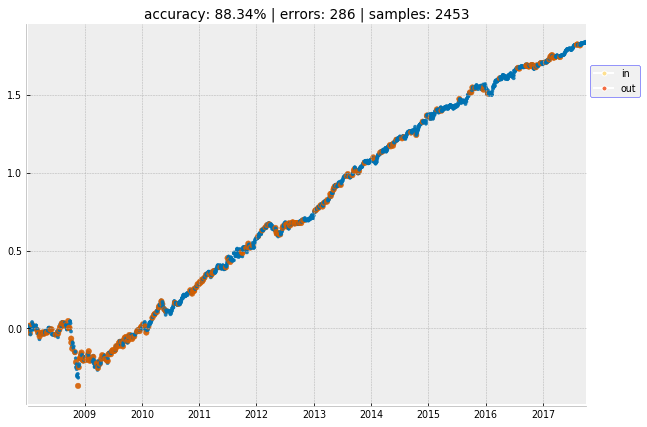

In [120]:
from pandas.tseries import converter
converter.register()

plot_preds(pred_df)

In [88]:
pred_df.groupby([pd.TimeGrouper('A')])['in_range'].count() - pred_df.groupby([pd.TimeGrouper('A')])['in_range'].sum()

Dates
2008-12-31    62
2009-12-31    55
2010-12-31    28
2011-12-31    40
2012-12-31    28
2013-12-31    14
2014-12-31    11
2015-12-31    20
2016-12-31    18
2017-12-31    10
Freq: A-DEC, Name: in_range, dtype: int64

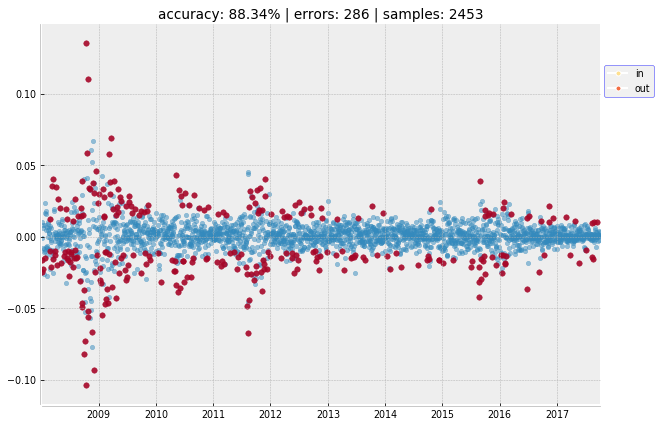

In [106]:
def plot_preds(df):
    #colors = sns.color_palette('cubehelix_r', 4)
    colors = sns.color_palette('RdYlBu', 4)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(df.query('in_range==1').index, df.query('in_range==1')['actual_return'], alpha=0.5, s=20,)
               #c=[colors[1] if x == 1 else colors[0] for x in df['in_range']])
               #c=[blue if x == 1 else red for x in df['in_range']])
    ax.scatter(df.query('in_range==0').index, df.query('in_range==0')['actual_return'], alpha=0.9, s=30,)
    #df['high_ci'].plot(ax=ax, alpha=0.65, marker='', color=colors[2])
    #df['low_ci'].plot(ax=ax, alpha=0.65, marker='', color=colors[3])
    ax.set_xlim(df.index[0], df.index[-1])

    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / df.shape[0]
    ax.set_title('accuracy: {:2.2%} | errors: {} | samples: {}'
                 .format(accuracy, df.shape[0] - nRight, df.shape[0]))

    win_kwds = dict(color="white", marker='o', markersize=5)
    in_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[1], **win_kwds)
    out_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[0], **win_kwds)
    ci_kwds = dict(color="white", marker='.', markersize=10)
    #hi_ci = mpl.lines.Line2D(range(1), range(
    #    1), markerfacecolor=colors[2], **ci_kwds)
    #lo_ci = mpl.lines.Line2D(range(1), range(
    #    1), markerfacecolor=colors[3], **ci_kwds)
    leg = ax.legend([in_, out_], ["in", "out"],
                    loc="center left", bbox_to_anchor=(1, 0.85), numpoints=1)
    leg.get_frame().set_edgecolor('blue')
    sns.despine(offset=2)
    
    
plot_preds(pred_df)    

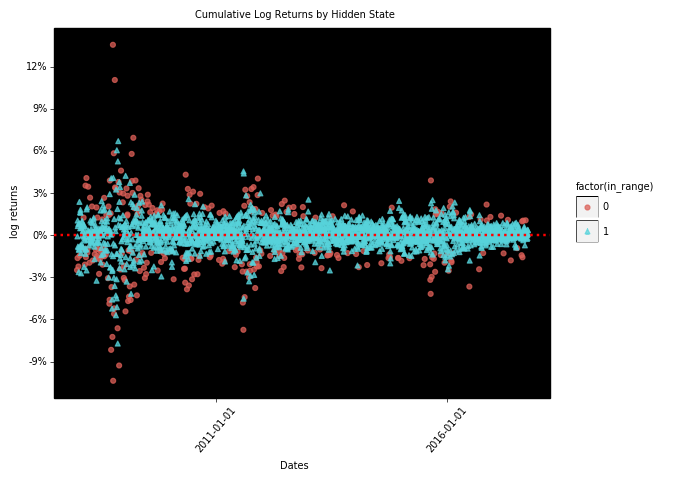

<ggplot: (8732289561110)>

In [111]:
def plot_cuml_state(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Dates',y='actual_return', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'), alpha=0.75)
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['actual_return'].min(), states['actual_return'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

### plot ###
df2 = pred_df.reset_index().assign(mkt_cret=lambda df: df.actual_return.cumsum())
plot_cuml_state(df2, 'in_range')

In [59]:
fake_dates = pd.date_range('2013','2014', freq='W')
fake_data = np.random.randn(len(fake_dates))

fake_dates, fake_data

(DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
                '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
                '2013-03-03', '2013-03-10', '2013-03-17', '2013-03-24',
                '2013-03-31', '2013-04-07', '2013-04-14', '2013-04-21',
                '2013-04-28', '2013-05-05', '2013-05-12', '2013-05-19',
                '2013-05-26', '2013-06-02', '2013-06-09', '2013-06-16',
                '2013-06-23', '2013-06-30', '2013-07-07', '2013-07-14',
                '2013-07-21', '2013-07-28', '2013-08-04', '2013-08-11',
                '2013-08-18', '2013-08-25', '2013-09-01', '2013-09-08',
                '2013-09-15', '2013-09-22', '2013-09-29', '2013-10-06',
                '2013-10-13', '2013-10-20', '2013-10-27', '2013-11-03',
                '2013-11-10', '2013-11-17', '2013-11-24', '2013-12-01',
                '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29'],
               dtype='datetime64[ns]', freq='W-SUN'),
 array([-

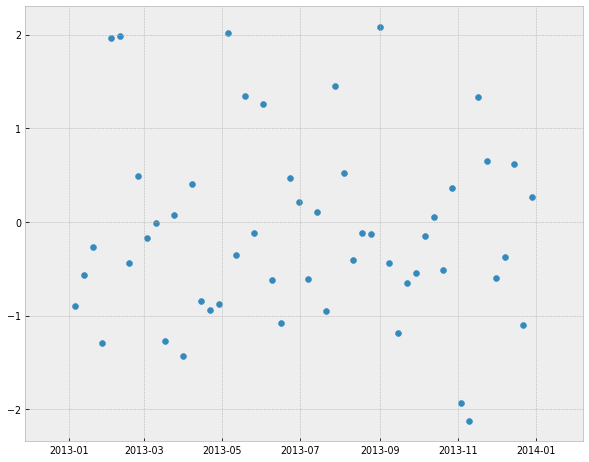

In [60]:


fig, ax = plt.subplots()
ax.scatter(fake_dates, fake_data)

In [56]:
print(mpl.get_backend())

module://ipykernel.pylab.backend_inline
